##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [32]:
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
keras.losses.Huber()

In [4]:
tf.__version__

'2.4.0'

In [5]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

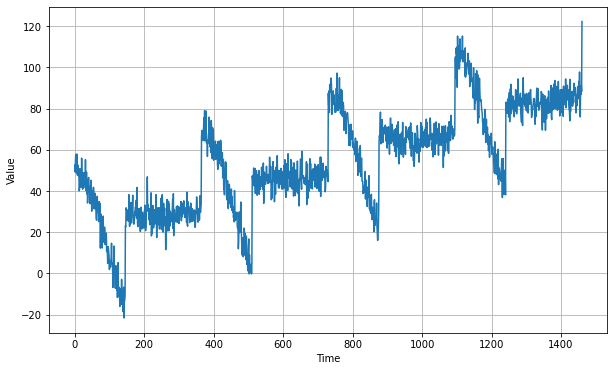

In [6]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [7]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [9]:
keras.losses.Huber()

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 9ms/step - loss: 67.9541 - mae: 68.4529 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 13.7751 - mae: 14.2655 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 10.6361 - mae: 11.1246 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 9.3667 - mae: 9.8515 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 9.4557 - mae: 9.9438 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 9.7406 - mae: 10.2282 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 9.4392 - mae: 9.9247 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss:

In [34]:
a = pd.DataFrame(train_set).iloc[0]

In [36]:
a[0]

<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[22.94573287, 34.8345837 , 33.02988157, 32.21988981, 32.26892324,
        29.09404767, 24.69727488, 29.59101265, 25.85480088, 34.14500269,
        28.56308528, 25.20002652, 27.74989436, 31.45096125, 26.59732959,
        25.33466534, 30.69418357, 30.73072443, 27.00148228, 27.21147442,
        30.75754331, 22.38765816, 22.62170452, 26.09790179, 28.65414135,
        31.3073226 , 37.1611257 , 34.10435352, 29.04822325, 29.78484383],
       [48.45021397, 50.12910673, 45.72569158, 44.56639491, 87.47922628,
        81.65220968, 88.61755981, 78.08375463, 91.7509904 , 88.96491441,
        87.86698147, 91.47340382, 94.84867031, 91.54275695, 77.20443311,
        79.9371394 , 83.12551031, 86.28303654, 88.63229718, 82.29519348,
        86.72619692, 81.87249287, 82.43751401, 78.29620464, 80.53652647,
        78.20629494, 79.88629019, 89.82379094, 79.58757709, 97.26461582],
       [44.96420617, 42.26699814, 31.47677838, 40.74902722, 34.05023834,

In [37]:
a[1]

<tf.Tensor: shape=(32,), dtype=float64, numpy=
array([24.89943429, 86.32665687, 22.74508593, 69.34064831, 82.29519348,
       56.90581692, 25.22132549, 44.97435873, 37.40691218, 31.88493202,
       27.35322905, 43.57180334, 20.68303577, 45.18442795, 63.04496227,
       26.09790179, 26.59732959, 10.8466037 , 20.65577173, 94.84867031,
       53.51929418, 28.92528864, 33.6586385 , 91.54275695, 54.34954933,
       31.52397911, 38.81262745, 41.22268301, 31.56368558,  1.92093036,
       50.69773572, 70.8203785 ])>

In [29]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 69.3251 - mae: 69.8247
Epoch 2/100
31/31 [==============================] - 0s 967us/step - loss: 56.6835 - mae: 57.1830
Epoch 3/100
31/31 [==============================] - 0s 957us/step - loss: 38.4334 - mae: 38.9326
Epoch 4/100
31/31 [==============================] - 0s 946us/step - loss: 21.3295 - mae: 21.8265
Epoch 5/100
31/31 [==============================] - 0s 950us/step - loss: 9.1823 - mae: 9.6700
Epoch 6/100
31/31 [==============================] - 0s 831us/step - loss: 8.1197 - mae: 8.6066
Epoch 7/100
31/31 [==============================] - 0s 838us/step - loss: 8.3267 - mae: 8.8070
Epoch 8/100
31/31 [==============================] - 0s 916us/step - loss: 7.5682 - mae: 8.0489
Epoch 9/100
31/31 [==============================] - 0s 943us/step - loss: 7.4296 - mae: 7.9114
Epoch 10/100
31/31 [==============================] - 0s 874us/step - loss: 7.9086 - mae: 8.3900
Epoch 11/100
31/31 [=============

KeyboardInterrupt: 

(1e-06, 0.001, 0.0, 20.0)

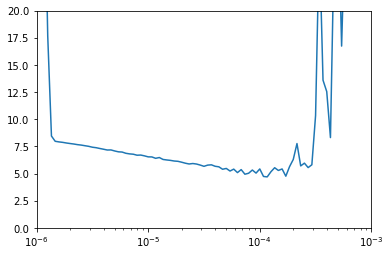

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 5ms/step - loss: 67.9541 - mae: 68.4529 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 13.7751 - mae: 14.2655 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 10.6361 - mae: 11.1246 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 9.3667 - mae: 9.8515 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 9.4557 - mae: 9.9438 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 9.7406 - mae: 10.2282 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 9.4392 - mae: 9.9247 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - loss:

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

In [17]:
lin_forecast.shape

(461,)

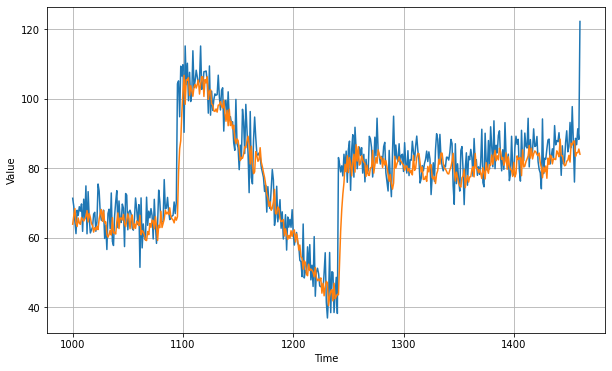

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662674

### Dense Model Forecasting

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 981us/step - loss: 43.3616 - mae: 43.8601
Epoch 2/100
31/31 [==============================] - 0s 862us/step - loss: 42.0590 - mae: 42.5571
Epoch 3/100
31/31 [==============================] - 0s 869us/step - loss: 38.8041 - mae: 39.3038
Epoch 4/100
31/31 [==============================] - 0s 836us/step - loss: 36.2801 - mae: 36.7800
Epoch 5/100
31/31 [==============================] - 0s 826us/step - loss: 31.8383 - mae: 32.3377
Epoch 6/100
31/31 [==============================] - 0s 851us/step - loss: 28.2799 - mae: 28.7788
Epoch 7/100
31/31 [==============================] - 0s 847us/step - loss: 23.7496 - mae: 24.2475
Epoch 8/100
31/31 [==============================] - 0s 827us/step - loss: 18.6970 - mae: 19.1927
Epoch 9/100
31/31 [==============================] - 0s 819us/step - loss: 13.6306 - mae: 14.1227
Epoch 10/100
31/31 [==============================] - 0s 827us/step - loss: 9.2946 - mae: 9.7853
Epoch 11/100
31/31 [=

(1e-07, 0.005, 0.0, 30.0)

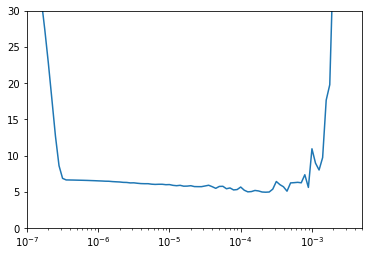

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 0s 6ms/step - loss: 29.0004 - mae: 29.4979 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 9.2173 - mae: 9.7037 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 8.2229 - mae: 8.7084 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 7.5460 - mae: 8.0330 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 7.4025 - mae: 7.8870 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 7.2160 - mae: 7.6998 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 7.2283 - mae: 7.7119 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - loss: 6.7374 

In [23]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

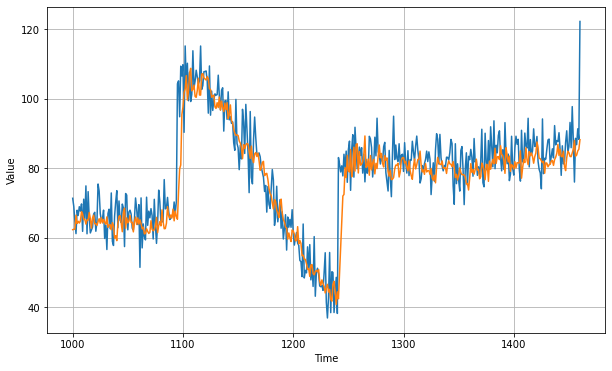

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2025547